# Bioacoustic analysis of DAS-recorded data

Author: [Léa Bouffaut](mailto:lb736'cornell.edu)
https://www.birds.cornell.edu/ccb/lea-bouffaut/


OptaSense QuantX data

### Initialization of the libraries

In [14]:
# Get the DAS4Whales package
!pip3 install 'git+https://github.com/leabouffaut/DAS4Whales.git'

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/leabouffaut/DAS4Whales.git to /private/var/folders/r3/47wgjrrx71vcvyvv6mmbfjkm0000gp/T/pip-req-build-oi7a2fy8
  Running command git clone --filter=blob:none --quiet https://github.com/leabouffaut/DAS4Whales.git /private/var/folders/r3/47wgjrrx71vcvyvv6mmbfjkm0000gp/T/pip-req-build-oi7a2fy8
  Resolved https://github.com/leabouffaut/DAS4Whales.git to commit b51473ec1aae0d7847ff429ae3272f5f48e5e8aa
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [10 lines of output]
      Traceback (most recent call last):
        File "<string>", line 36, in <module>
        File "<pip-setuptools-caller>", 

## Get a DAS data
Here, we check if file example "filename" already exists else, download a .hdf5 file from the OOI DAS experiment
Experiment information can be found at:  https://oceanobservatories.org/pi-instrument/rapid-a-community-test-of-distributed-acoustic-sensing-on-the-ocean-observatories-initiative-regional-cabled-array/

Files are ~850 MB so the download can take a while

In [2]:
import wget
import os

filename = 'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T020002Z.h5'

if os.path.exists(filename) == True:
    print(filename, ' already exists in path')
else:
    url = 'http://piweb.ooirsn.uw.edu/das/data/Optasense/NorthCable/TransmitFiber/' \
          'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-03T15_06_51-0700/' \
          'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5'
           
    das_example_file = wget.download(url)
    print(['Downloaded: ', das_example_file])

North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T020002Z.h5  already exists in path


## Get information on the DAS data

In [3]:
import das4whales as dw
import scipy.signal as sp
import numpy as np

# Read HDF5 files and access metadata
# Get the acquisition parameters for the data folder
fs, dx, nx, ns, gauge_length, scale_factor = dw.data_handle.get_acquisition_parameters(filename)

print('Sampling frequency: ', fs, ' Hz')
print('Gauge length: ', gauge_length, ' m')
print('File duration: ', ns/fs, ' s')
print('Channel spacing: ', dx, ' m')
print('Number of channels: ', nx)
print('Number of time samples: ', ns)

Sampling frequency:  200.0  Hz
Gauge length:  51.04762  m
File duration:  60.0  s
Channel spacing:  2.0419047  m
Number of channels:  32600
Number of time samples:  12000


## Select the desired channels and channel interval

In [4]:
selected_channels_m = [20000, 65000, 10]  # list of values in meters corresponding to the starting,
                                          # ending and step wanted channels along the FO Cable
                                          # selected_channels_m = [ChannelStart_m, ChannelStop_m, ChannelStep_m]
                                          # in meters

selected_channels = [int(selected_channels_m // dx) for selected_channels_m in
                     selected_channels_m]  # list of values in channel number (spatial sample) corresponding to the starting, ending and step wanted
                                           # channels along the FO Cable
                                           # selected_channels = [ChannelStart, ChannelStop, ChannelStep] in channel
                                           # numbers

print('Begin channel #:', selected_channels[0], 
      ', End channel #: ',selected_channels[1], 
      ', step: ',selected_channels[2], 
      'equivalent to ',selected_channels[2]*dx,' m')


Begin channel #: 9794 , End channel #:  31833 , step:  4 equivalent to  8.167618751525879  m


## Create the filters to condition the signal

In [5]:
# Create band-pass filter for the TX plots
sos_bpfilter = dw.dsp.butterworth_filter([5, [10, 30], 'bp'], fs)

# Create high-pass filter
sos_hpfilter = dw.dsp.butterworth_filter([2, 5, 'hp'], fs)

## Load raw DAS data

In [6]:
# Load DAS data
tr, time, dist, fileBeginTimeUTC = dw.data_handle.load_das_data(filename, fs, dx, selected_channels, scale_factor)

## Apply band-pass filter and plot

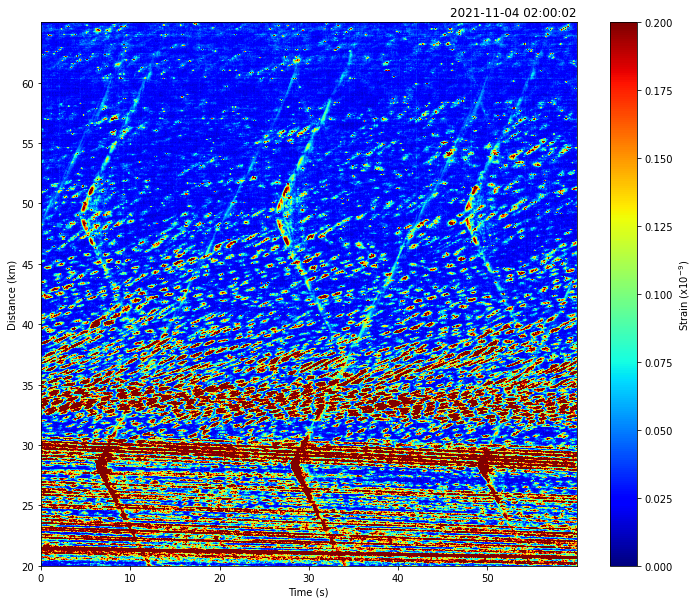

In [7]:
# band-pass filter
trf = sp.sosfiltfilt(sos_bpfilter, tr, axis=1)

# Plot
dw.plot.plot_tx(trf, time, dist, fileBeginTimeUTC, fig_size=(12, 10))

## Apply f-k and plot

In [8]:
# Create the f-k filter
fk_filter = dw.dsp.fk_filter_design((trf.shape[0],trf.shape[1]), selected_channels, dx, fs, cs_min=1400, cp_min=1480, cp_max=3400, cs_max=3500)

# Apply the f-k filter to the data
trf_fk = dw.dsp.fk_filter_filt(trf,fk_filter)

# Plot
dw.plot.plot_tx(trf_fk, time, dist, fileBeginTimeUTC, fig_size=(12, 10))

AttributeError: module 'das4whales.dsp' has no attribute 'fk_filter'

In [ ]:
# Spatio-spectral plot
dw.plot.plot_fx(trf_fk, dist, fs, win_s=2,  nfft=512, f_min=0, f_max=50, fig_size=(25, 10))

In [ ]:
from IPython.display import Audio

# read one channel only as audio
sel_chan = 27000 # (m)
idx = (np.abs(dist - sel_chan)).argmin()

# Spectrogram
p,tt,ff = dw.dsp.get_spectrogram(trf_fk[idx,:], fs, nfft=128, overlap_pct=0.8)
dw.plot.plot_spectrogram(p, tt,ff)
Audio(data=trf_fk[idx,:], rate=fs*5)


In [ ]:

# read one channel only as audio
sel_chan = 50000 # (m)
idx = (np.abs(dist - sel_chan)).argmin()

# Spectrogram
p = get_spectrogram(trf_fk[idx,:])
plot_spectrogram(p, fs,  ns/fs, scale='linear')


# Play audio
Audio(data=trf_fk[idx,:], rate=fs*5)